In [1]:
__author__ = '@Tssp'
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from codvidutils.Autoencoder_Transformation_main import Transformation_main
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

Using TensorFlow backend.


# Prepare dataset

In [2]:
outputs = Transformation_main('data/train_split_v4.csv', 'data/test_split_v4.csv')
Y_test = outputs['Y_test']
encoder_train = outputs['encoder_train']
encoder_test = outputs['encoder_test']
del outputs

You are going to read from: data/train_split_v4.csv and data/test_split_v4.csv
Total number of images: 1540
shape X: 13600 1540,  disease_ID (Y): 13600 1540
Count of classes:  Counter({0: 7966, 2: 5447, 1: 187})
New diseaseID shape:  (9097,)
New X shape:  (9097, 120000)
New Count of classes:  Counter({0: 4500, 2: 4500, 1: 97})
Undersample shapes:
diseaseID_train.shape: (9097,)
X_train.shape: (9097, 120000)
X_train.shape: (9097, 200, 200, 3)
X_test.shape: (1540, 200, 200, 3)
Normal train:  (4500,)
Pneumonia train:  (4500,)
COVID train:  (97,)
*******************************************************
Normal test:  (885,)
Pneumonia test:  (591,)
COVID test:  (64,)
(2425, 180, 180, 3)
(2425,)
X_train.shape:  (11522, 180, 180, 3)
diseaseID_train.shape:  (11522,)
X_test_news.shape:  (1600, 180, 180, 3)
diseaseID_test_news.shape:  (1600,)
X_test.shape:  (3140, 180, 180, 3)
diseaseID_test.shape:  (3140,)
encoder_test.shape (3140, 23, 23, 64)
encoder_train.shape (11522, 23, 23, 64)


# XGBoost

## Regressor:

In [3]:
predsr = np.loadtxt('log/preds_XGBr_lr0.005_n250_maxdepth3.txt', delimiter=',')
nocovid = predsr[np.where(Y_test == 0)]
covid = predsr[np.where(Y_test == 1)]
cut_nocovid = np.max(nocovid)

In [4]:
cut_nocovid

0.6822584867477417

1474 of 1474 no COVID-19 (100.0%)
71 of 1664 COVID-19 (4.27%)
[[1474    0]
 [1593   71]]
cm normalized:
 [[1.         0.        ]
 [0.95733173 0.04266827]]


Text(0.5,0,'Predicted')

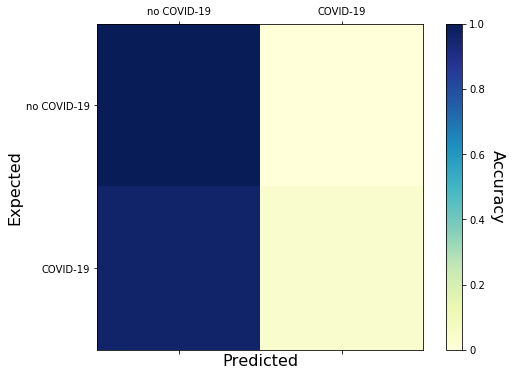

In [7]:
TP_050 = np.count_nonzero(np.where((Y_test==0) & (predsr<0.50)))
FN_050 = np.count_nonzero(np.where((Y_test==1) & (predsr>0.50)))
FP_050 = np.count_nonzero(np.where((Y_test==1) & (predsr<0.50)))
TN_050 = np.count_nonzero(np.where((Y_test==0) & (predsr>0.50)))
TP_070 = np.count_nonzero(np.where((Y_test==0) & (predsr<cut_nocovid)))
FN_070 = np.count_nonzero(np.where((Y_test==1) & (predsr>cut_nocovid)))
FP_070 = np.count_nonzero(np.where((Y_test==1) & (predsr<cut_nocovid)))
TN_070 = np.count_nonzero(np.where((Y_test==0) & (predsr>cut_nocovid)))
cm = np.array([[TP_050, TN_050],[FP_050, FN_050]])
cm = np.array([[TP_070, TN_070],[FP_070, FN_070]])
print('{} of {} no COVID-19 ({:2.4}%)'.format(cm[0,0], cm[0,0] + cm[0,1], 100*cm[0,0]/(cm[0,0]+cm[0,1])))
print('{} of {} COVID-19 ({:2.3}%)'.format(cm[1,1], cm[1,1] + cm[1,0], 100*cm[1,1]/(cm[1,1]+cm[1,0])))
print(cm)
cm = normalize(cm, 'l1')
print("cm normalized:\n", cm)
labels = ['no COVID-19', 'COVID-19']
fig1, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='YlGnBu', vmin=0, vmax=1)
cbar = fig1.colorbar(cax)
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.set_ticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1.0'])
cbar.ax.set_ylabel('Accuracy', rotation=270, labelpad=20, fontsize=16)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.set_ylabel('Expected', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
#fig1.savefig('Figures/cm_XGBregressor_lr0005_n250_maxdepth3.png', dpi=200)

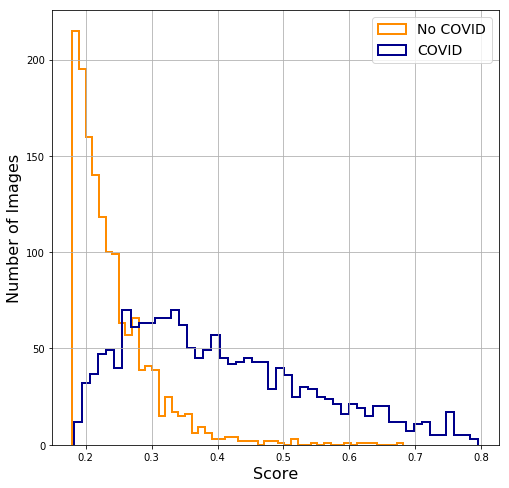

In [10]:
fig2, ax = plt.subplots(figsize=(8,8))
ax.hist(nocovid, 50, histtype='step', lw=2, color='darkorange', label='No COVID')
ax.hist(covid, 50, histtype='step', lw=2, color='darkblue', label='COVID')
plt.grid()
ax.set_ylabel('Number of Images', fontsize=16)
ax.set_xlabel('Score', fontsize=16)
plt.legend( loc='upper right', fontsize=14)
plt.yscale("linear")
#fig2.savefig('Figures/histogram_XGBregressor_lr0005_n250_maxdepth3.png', dpi=200)